In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import h5py
import numpy as np
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.model import *
from src.Data_Processing import *

In [ ]:
# Define the data directory (adjust this path if necessary)
data_dir = 'BraTS2020_training_data/content/small_data/'

# Get list of .h5 files
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Ensure that there are .h5 files in the directory
if not h5_files:
    raise FileNotFoundError(f"No .h5 files found in the directory: {data_dir}")

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.2, random_state=42)

print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Parameters
batch_size = 16  # Adjust based on GPU memory

image_dim = (128, 128)  # Adjust based on your image dimensions

shuffle = True

dataset = UNetDataset(train_files, data_dir, image_dim)
    
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Assuming train_files and data_dir are defined
filename = os.path.join(data_dir, train_files[-15])

show_single_h5_file(filename)

In [ ]:
# Define the model
model = UNet(in_channels=2, out_channels=1)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        """
        Dice Loss for image segmentation.

        Parameters:
        - smooth: Smoothing factor to avoid division by zero.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        Compute Dice Loss.

        Parameters:
        - preds: Model predictions (logits or probabilities), shape (N, C, H, W)
        - targets: Ground truth masks (binary), shape (N, C, H, W)

        Returns:
        - dice_loss: Computed Dice loss
        """
        preds = torch.sigmoid(preds)  # Ensure values are between 0 and 1
        preds = preds.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        return 1 - dice_coeff  # Dice loss = 1 - Dice coefficient

criterion = DiceLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(dataloader, model, device, criterion, optimizer, num_epochs=10)

In [39]:
def single_volume(volume_index, data_dir, slice_range = 155, idx = 0):

    volume_list=[]
    
    for slice_idx in range(slice_range):
        
        # Construct the filename
        filename = os.path.join(data_dir, f"volume_{volume_index}_slice_{slice_idx}.h5")
        
        # Check if the file exists before adding to the list
        if os.path.exists(filename):
            
            with h5py.File(filename, 'r') as h5_file:
                
                mask = h5_file["mask"][:]

                volume_list.append(mask[:,:,idx])
        else:
            print(f"File {filename} does not exist.")

    return np.array(volume_list)

In [70]:
def data_distribution(volume_index, data_dir, slice_range = 155, idx = 0):

    pixel_list=[]
    
    for slice_idx in range(slice_range):
        
        # Construct the filename
        filename = os.path.join(data_dir, f"volume_{volume_index}_slice_{slice_idx}.h5")
        
        # Check if the file exists before adding to the list
        if os.path.exists(filename):
            
            with h5py.File(filename, 'r') as h5_file:
                
                mask = h5_file["mask"][:]

                pixel_list.append(np.sum(mask[:,:,idx]))
        else:
            print(f"File {filename} does not exist.")

    return pixel_list

# Example usage:
vol_low, vol_high = 1, 370

slice_range = 155

idx_total = 3

distribution_data_np1 = np.zeros((vol_high-vol_low, slice_range, idx_total)) 

distribution_data_np2 = np.zeros((vol_high-vol_low, slice_range, idx_total))

for idx in range(idx_total):

    for i,volume in enumerate(range(vol_low, vol_high)):  # Volume number (e.g., 'volume_1')
        
        data_dir = "C:/Users/somas/CS425_Project/BraTS2020_training_data/content/data/"  # Path to your data directory
        # Get the filenames for the specified volume and slices
        
        distribution_data_np1[i,:,idx]= data_distribution(volume, data_dir, slice_range = slice_range, idx=idx)
    
        distribution_data_np2[i,:,idx][distribution_data_np1[i,:,idx]>0]=1

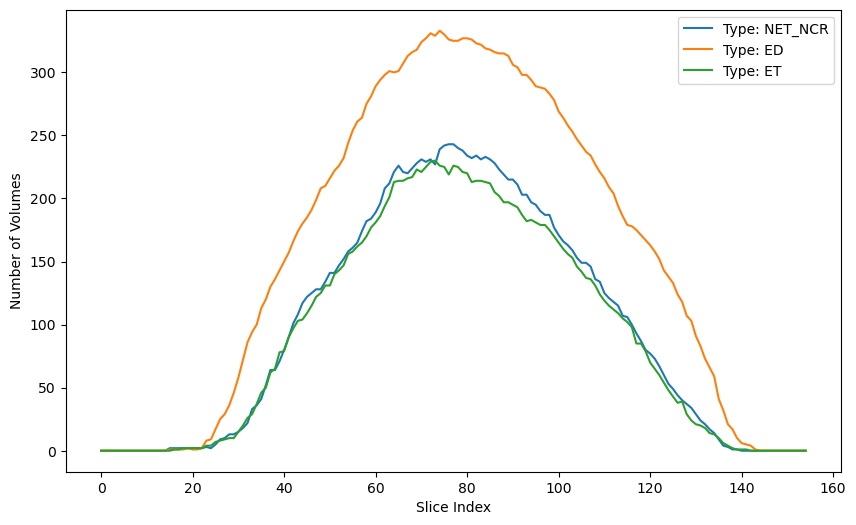

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(distribution_data, volume_indices, slice_indices, idx, filename_prefix):
    # Map idx to the appropriate name
    title_map = {0: "NET_NCR", 1: "ED", 2: "ET"}
    title = f"{title_map[idx]} Pixel Distribution Across Volumes and Slices"
    filename = f"Figure/{filename_prefix}_{title_map[idx]}_heatmap.jpg"
    
    plt.figure(figsize=(10, 6))
    plt.imshow(distribution_data, aspect="auto", cmap="viridis", interpolation="nearest")
    plt.colorbar(label=f"Total {title_map[idx]} Pixels")
    plt.xlabel("Slice Index")
    plt.ylabel("Volume Index")
    plt.title(title)
    
    num_xticks = min(10, len(slice_indices))
    num_yticks = min(10, len(volume_indices))

    xtick_positions = np.linspace(0, len(slice_indices) - 1, num_xticks, dtype=int)
    ytick_positions = np.linspace(0, len(volume_indices) - 1, num_yticks, dtype=int)

    plt.xticks(ticks=xtick_positions, labels=slice_indices[xtick_positions])
    plt.yticks(ticks=ytick_positions, labels=volume_indices[ytick_positions])
    plt.savefig(filename, dpi=600, bbox_inches="tight")
    plt.show()
   

def plot_cumulative_distribution(distribution_data, volume_indices, idx, filename_prefix):
    # Map idx to the appropriate name
    title_map = {0: "NET_NCR", 1: "ED", 2: "ET"}
    title = f"Cumulative Distribution of {title_map[idx]} Pixels per Volume"
    filename = f"Figure/{filename_prefix}_{title_map[idx]}_cumsum.jpg"

    plt.figure(figsize=(10, 6))

    for i, volume in enumerate(volume_indices):
        # Avoid division by zero by checking if sum is zero
        data_sum = np.sum(distribution_data[i, :])
        if data_sum > 0:
            cumsum_data = np.cumsum(distribution_data[i, :]) / data_sum
        else:
            cumsum_data = np.zeros_like(distribution_data[i, :])  # Set to zero if sum is zero
        
        plt.plot(cumsum_data, label=f"Volume {volume}")

    plt.xlabel("Slice Index")
    plt.ylabel("Cumulative Sum (Normalized)")
    plt.title(title)
    plt.legend(ncol=3)
    plt.grid()
    plt.savefig(filename, dpi=600, bbox_inches="tight")
    plt.show()

# Plotting function for heatmaps and cumulative sums for different idx values
def plot_for_idx(distribution_data_np1, distribution_data_np2, idx_value, vol_low, vol_high, slice_range):
    
    volume_indices = np.arange(vol_low, vol_high)
    
    slice_indices = np.arange(slice_range)

    # plot_graph(distribution_data_np2, volume_indices, slice_indices, idx, "Binary")

     # Map idx to the appropriate name
    title_map = {0: "NET_NCR", 1: "ED", 2: "ET"}
    
    # title = f"{title_map[idx]} Pixel Distribution Across Volumes and Slices"
    
    filename = f"Figure/Binary_dist_plot.jpg"
    
    plt.figure(figsize=(10, 6))

    for i in range(3):
        
        plt.plot(np.sum(distribution_data_np2[:,:,i],axis=0), label = f"Type: {title_map[i]}")
        # plt.colorbar(label=f"Total {title_map[idx]} Pixels")
        plt.xlabel("Slice Index")
        plt.ylabel("Number of Volumes")
        # plt.title(title)
        
        num_xticks = min(10, len(slice_indices))
        # num_yticks = min(10, len(volume_indices))
    
        xtick_positions = np.linspace(0, len(slice_indices) - 1, num_xticks, dtype=int)
        ytick_positions = np.linspace(0, len(volume_indices) - 1, num_yticks, dtype=int)
    
        # plt.xticks(ticks=xtick_positions, labels=slice_indices[xtick_positions])
        # plt.yticks(ticks=ytick_positions, labels=volume_indices[ytick_positions])
        plt.savefig(filename, dpi=600, bbox_inches="tight")
        plt.show()

    # for idx in range(idx_value):
        # # Heatmap plots
        # plot_heatmap(distribution_data_np1[:,:,idx], volume_indices, slice_indices, idx, "Total")
        
        # plot_heatmap(distribution_data_np2[:,:,idx], volume_indices, slice_indices, idx, "Binary")

        # plot_graph(distribution_data_np1[:,:,idx], volume_indices, slice_indices, idx, "Total")


        # # Cumulative distribution plots
        # volume_indices_sp = np.arange(vol_low, vol_high, 10)
        # distribution_data_sp1 = distribution_data_np1[:,:,idx][:-1:10, :]
        # plot_cumulative_distribution(distribution_data_sp1, volume_indices_sp, idx, "Total")
        
        # distribution_data_sp2 = distribution_data_np2[:,:,idx][:-1:10, :]
        # plot_cumulative_distribution(distribution_data_sp2, volume_indices_sp, idx, "Binary")

# Example usage:
vol_low, vol_high = 1, 370
slice_range = 155
idx_value = 3  # Set idx_value to the number of different distributions you're working with

# Call the plotting function for idx=0, 1, 2
# plot_for_idx(distribution_data_np1, distribution_data_np2, idx_value, vol_low, vol_high, slice_range)

title_map = {0: "NET_NCR", 1: "ED", 2: "ET"}
    
# title = f"{title_map[idx]} Pixel Distribution Across Volumes and Slices"

filename = f"Figure/Binary_dist_plot.jpg"

plt.figure(figsize=(10, 6))

for i in range(3):
    
    plt.plot(np.sum(distribution_data_np2[:,:,i],axis=0), label = f"Type: {title_map[i]}")
    # plt.colorbar(label=f"Total {title_map[idx]} Pixels")
    plt.xlabel("Slice Index")
    plt.ylabel("Number of Volumes")
    # plt.title(title)
    
    num_xticks = min(10, len(slice_indices))
    # num_yticks = min(10, len(volume_indices))

    xtick_positions = np.linspace(0, len(slice_indices) - 1, num_xticks, dtype=int)
    ytick_positions = np.linspace(0, len(volume_indices) - 1, num_yticks, dtype=int)

    # plt.xticks(ticks=xtick_positions, labels=slice_indices[xtick_positions])
    # plt.yticks(ticks=ytick_positions, labels=volume_indices[ytick_positions])
plt.legend()
plt.savefig(filename, dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# Example usage:
vol_low, vol_high = 1, 370

slice_range = 155

distribution_data_np = np.zeros((vol_high-vol_low, slice_range)) 

for i,volume in enumerate(range(vol_low, vol_high)):  # Volume number (e.g., 'volume_1')
    
    data_dir = "BraTS2020_training_data/content/data/"  # Path to your data directory
    # Get the filenames for the specified volume and slices
    
    distribution_data_np[i,:] = data_distribution(volume, data_dir, slice_range = slice_range, idx=1)

In [ ]:
# Plot the heatmap
volume_indices = np.arange(vol_low, vol_high)
slice_indices = np.arange(slice_range)
plt.figure(figsize=(10, 6))
plt.imshow(distribution_data_np, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Total ED Pixels")
plt.xlabel("Slice Index")
plt.ylabel("Volume Index")
plt.title("ED Pixel Distribution Across Volumes and Slices")

# Reduce xticks and yticks to just 10
num_xticks = min(10, len(slice_indices))  # Ensure we don't exceed available ticks
num_yticks = min(10, len(volume_indices))

xtick_positions = np.linspace(0, len(slice_indices) - 1, num_xticks, dtype=int)
ytick_positions = np.linspace(0, len(volume_indices) - 1, num_yticks, dtype=int)

plt.xticks(ticks=xtick_positions, labels=slice_indices[xtick_positions])
plt.yticks(ticks=ytick_positions, labels=volume_indices[ytick_positions])
plt.savefig(f"Figure/ED_heatmap.jpg", dpi = 600, bbox_inches = "tight")

plt.show()

In [ ]:
# Generate volume and slice indices
volume_indices = np.arange(vol_low, vol_high, 10)

distribution_data_sp = distribution_data_np[:-1:10,:]

# Plot cumulative sum histograms
plt.figure(figsize=(12, 6))

# Individual cumulative histogram for each volume
for i, volume in enumerate(volume_indices):
    plt.plot(
        np.cumsum(distribution_data_sp[i, :]) / np.sum(distribution_data_sp[i, :]), 
        label=f"Volume {volume}"
    )

plt.xlabel("Slice Index")
plt.ylabel("Cumulative Sum (Normalized)")
plt.title("Cumulative Distribution of ED Pixels per Volume")
plt.legend(ncol=3)
plt.grid()
plt.savefig(f"Figure/ED_cumsum.jpg", dpi = 600, bbox_inches = "tight")
plt.show()

In [ ]:
# Example usage:
vol_low, vol_high = 0, 369

slice_range = 155

distribution_data_np = np.zeros((vol_high-vol_low, slice_range)) 

for i,volume in enumerate(range(vol_low, vol_high)):  # Volume number (e.g., 'volume_1')
    
    data_dir = "BraTS2020_training_data/content/data/"  # Path to your data directory
    # Get the filenames for the specified volume and slices
    
    distribution_data_np[i,:] = data_distribution(volume_index, data_dir, slice_range = slice_range, idx=2)

In [ ]:
# Plot the heatmap
volume_indices = np.arange(vol_low, vol_high)
slice_indices = np.arange(slice_range)
plt.figure(figsize=(10, 6))
plt.imshow(distribution_data_np, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Total ET Pixels")
plt.xlabel("Slice Index")
plt.ylabel("Volume Index")
plt.title("ET Pixel Distribution Across Volumes and Slices")

# Reduce xticks and yticks to just 10
num_xticks = min(10, len(slice_indices))  # Ensure we don't exceed available ticks
num_yticks = min(10, len(volume_indices))

xtick_positions = np.linspace(0, len(slice_indices) - 1, num_xticks, dtype=int)
ytick_positions = np.linspace(0, len(volume_indices) - 1, num_yticks, dtype=int)

plt.xticks(ticks=xtick_positions, labels=slice_indices[xtick_positions])
plt.yticks(ticks=ytick_positions, labels=volume_indices[ytick_positions])
plt.savefig(f"ET_heatmap.jpg", dpi = 600, bbox_inches = "tight")

plt.show()

In [ ]:
# Generate volume and slice indices
volume_indices = np.arange(vol_low, vol_high, 10)

distribution_data_sp = distribution_data_np[:-1:10,:]

# Plot cumulative sum histograms
plt.figure(figsize=(12, 6))

# Individual cumulative histogram for each volume
for i, volume in enumerate(volume_indices):
    plt.plot(
        np.cumsum(distribution_data_sp[i, :]) / np.sum(distribution_data_sp[i, :]), 
        label=f"Volume {volume}"
    )

plt.xlabel("Slice Index")
plt.ylabel("Cumulative Sum (Normalized)")
plt.title("Cumulative Distribution of ET Pixels per Volume")
plt.legend(ncol=3)
plt.grid()
plt.savefig(f"ET_cumsum.jpg", dpi = 600, bbox_inches = "tight")
plt.show()